In [221]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn import tree  # decision tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import ShuffleSplit, KFold, train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
import sklearn.base
from sklearn.metrics import r2_score
from collections import defaultdict

import scipy as sp

base_dir = '/Users/james/Data_Incubator/LC_app'
#base_dir = os.path.dirname(os.path.realpath(__file__))
sys.path.append(base_dir)
import LC_helpers as LCH
import LC_loading as LCL
import LC_models as LCM

%matplotlib inline


In [2]:
#set paths
data_dir = os.path.join(base_dir,'static/data/')
fig_dir = os.path.join(base_dir,'static/images/')
movie_dir = os.path.join(base_dir,'static/movies/')

#load data 
data_name = 'all_loans_proc'
LD = pd.read_csv(data_dir + data_name, parse_dates=['issue_d',])
#LD['collections_12_mths_ex_med'].fillna(0,inplace=True)  # get rid of a few nan values

#load long/lat data for each zip-code
zip3_data = LCL.load_location_data(group_by='zip3')        
LD = pd.merge(LD,zip3_data,how='inner', left_on='zip3', right_index=True)



In [170]:
#%%
ordinal_cols = ['time','int_rate','term','funded_amnt','longitude','latitude',
                    'collections_12_mths_ex_med','delinq_2yrs','desc_length',
                    'dti','cr_line_dur','emp_length',
                    'annual_inc','open_acc','mths_since_last_delinq',
                    'inq_last_6mths','mths_since_last_delinq','mths_since_last_record',
                    'pub_rec','revol_bal','total_acc']
geographic = ['longitude','latitude']  # lump these two under a single category heading
use_categories = ['purpose','home_ownership']  # these are the categorical predictors

times = (LD.issue_d - LD.issue_d.min()).dt.days.values
min_time = np.min(times)
max_time = np.max(times)
LD['time'] = times

# take all predictors into a numpy array and keep track of the column indices associated 
# with each predictor
X = LD[ordinal_cols].values  # predictor variables
#y = LD['weighted_ROI']  # response variable
y = LD['ROI']  # response variable
npymnts = LD['num_pymnts']
LD['weight_y'] = LD['mnthly_ROI'] * LD['num_pymnts']
weight_y = LD['weight_y']

# dict keyed by predictor name, with set of column indices as the values
col_dict = {name: [idx] for idx, name in enumerate(ordinal_cols)}  
# either ord or cat (is predictor categorical)
col_types = {name: 'ord' for name in ordinal_cols} 
# add lat/long coordinates as 'location'
col_dict['location'] = np.arange(2) + X.shape[1]
col_types['location'] = 'ord'  
X = np.concatenate((X,LD[geographic].values), axis=1)
for cat in use_categories: # add categorical predictors
    dummyX = pd.get_dummies(LD[cat])
    col_dict[cat] = np.arange(dummyX.shape[1]) + X.shape[1]
    col_types[cat] = 'cat'
    X = np.concatenate((X, dummyX.values), axis=1)


In [213]:
def gaussian_RBF(time_pts, cent, scale):
    dist = ((time_pts - cent) / scale) **2
    weights = np.exp(-dist)
    return weights

class random_grove_mod(sklearn.base.BaseEstimator, sklearn.base.RegressorMixin):
    ''''''
    def __init__(self, weight_fun, patch_grid, patch_scale, trees_per_mod=10,
                 mods_per_patch=10, max_depth=12, min_samples_leaf=50):
        self.weight_fun = weight_fun
        self.patch_grid = patch_grid
        self.patch_scale = patch_scale
        self.mods_per_patch = mods_per_patch
        self.trees_per_mod = trees_per_mod
        self.patches = []
        for patch_id in xrange(len(patch_grid)):
            cur_patch = [RandomForestRegressor(n_estimators=trees_per_mod, max_depth=max_depth, 
                                                min_samples_leaf=min_samples_leaf, 
                                               n_jobs=-1, bootstrap=False) \
                         for _ in xrange(mods_per_patch)]
            
            self.patches.append(cur_patch)

    def fit(self, X, y):
        time = X[:,0] #convention that first column of X is time
        n_pts = len(y)
        for patch_id, patch_loc in enumerate(self.patch_grid):
            print('fitting patch {} of {}'.format(patch_id, len(self.patch_grid)))
            weights = self.weight_fun(time, patch_loc, self.patch_scale)
            for tree_idx in xrange(self.mods_per_patch):
                sample = np.random.choice(n_pts,size=n_pts,replace=True)
                sample = sample[(np.random.rand(n_pts) < weights[sample])]
#                 print('fitting tree {} of {} with {} points'.format(tree_idx, 
#                                 self.mods_per_patch, len(sample)))
                self.patches[patch_id][tree_idx].fit(X[sample,1:],y[sample])                
        return self
    
    def predict(self, X):       
        n_pts = X.shape[0]
        patch_weights = np.zeros((len(self.patch_grid),n_pts))
        patch_preds = np.zeros((len(self.patch_grid),n_pts))
        for patch_id, patch_loc in enumerate(self.patch_grid):
            patch_weights[patch_id,:] = self.weight_fun(X[:,0], patch_loc, self.patch_scale)                        
            tree_preds = np.zeros((self.mods_per_patch,n_pts))
            for tree_idx in xrange(self.mods_per_patch):
                tree_preds[tree_idx,:] = self.patches[patch_id][tree_idx].predict(X[:,1:])
            patch_preds[patch_id,:] = np.mean(tree_preds,axis=0)
        
        return np.sum(patch_weights * patch_preds, axis=0) / np.sum(patch_weights, axis=0)


In [236]:
n_patches = 5
patch_grid = np.linspace(min_time,max_time,n_patches)
patch_scale = 1000.
mods_per_patch = 100
trees_per_mod = 1
min_samples_leaf = 100
max_depth = 10
use_cols = ['time','int_rate','term','funded_amnt','location','home_ownership','purpose',
                    'collections_12_mths_ex_med','delinq_2yrs','desc_length',
                    'dti','cr_line_dur','emp_length', 'annual_inc','open_acc',
                    'mths_since_last_delinq', 'inq_last_6mths',
                    'mths_since_last_record','pub_rec','revol_bal','total_acc']
RG_mod = random_grove_mod(gaussian_RBF, patch_grid, patch_scale,trees_per_mod=trees_per_mod,
                         mods_per_patch=mods_per_patch, max_depth=max_depth,
                          min_samples_leaf=min_samples_leaf)

col_sel = LCM.col_selector(use_cols, col_dict)
RG_pipeline = Pipeline([('col_sel',col_sel),('est',RG_mod)])


#dont use time for basic RF model 
use_cols = ['int_rate','term','funded_amnt','location','home_ownership','purpose',
                    'collections_12_mths_ex_med','delinq_2yrs','desc_length',
                    'dti','cr_line_dur','emp_length', 'annual_inc','open_acc',
                    'mths_since_last_delinq', 'inq_last_6mths',
                    'mths_since_last_record','pub_rec','revol_bal','total_acc']
RF_mod = RandomForestRegressor(n_estimators=trees_per_mod*mods_per_patch, max_depth=max_depth,
                               min_samples_leaf=min_samples_leaf,n_jobs=4)
RF_pipeline = Pipeline([('col_sel',col_sel),('est',RF_mod)])

In [237]:
shuf_split = ShuffleSplit(len(LD), n_iter=1, test_size=0.1)
for train, test in shuf_split:
    RG_pipeline.fit(X[train,:],y.iloc[train].values)
    RF_pipeline.fit(X[train,:],y.iloc[train].values)

    RG_pred_y = RG_pipeline.predict(X[train,:])
    RF_pred_y = RF_pipeline.predict(X[train,:])

    RG_train_r2 = r2_score(y.iloc[train],RG_pred_y)
    RF_train_r2 = r2_score(y.iloc[train],RF_pred_y)

    RG_pred_y = RG_pipeline.predict(X[test,:])
    RF_pred_y = RF_pipeline.predict(X[test,:])
    
    RG_test_r2 = r2_score(y.iloc[test],RG_pred_y)
    RF_test_r2 = r2_score(y.iloc[test],RF_pred_y)

fitting patch 0 of 5
fitting patch 1 of 5
fitting patch 2 of 5
fitting patch 3 of 5
fitting patch 4 of 5


In [238]:
print('RF, RG train: {}, {};  RF, RG test: {}, {}'.format(RF_train_r2, RG_train_r2, RF_test_r2, RG_test_r2))

RF, RG train: 0.0244125978198, 0.0243794211414;  RF, RG test: 0.0140870576848, 0.0119522556313


In [216]:
pred_y = RG_pipeline.predict(X[test,:])
print(np.corrcoef(y.iloc[test].values, pred_y))

[[ 1.          0.09167464]
 [ 0.09167464  1.        ]]


In [7]:
time_ax = (LD.issue_d - LD.issue_d.min()).dt.days
min_time = time_ax.min()
max_time = time_ax.max()
n_kern_pos = 10
kernel_spacing = np.linspace(min_time,max_time,n_kern_pos)
kernel_SD = np.mean(np.diff(kernel_spacing))/2.

In [128]:
# def get_weights(time_pts, base_cent, base_width):
#     weights = 1.5 * np.exp(-(time_pts - base_cent)**2 / (2*base_width**2))
#     weights[weights > 1] = 1    
#     return weights

# def get_weights(time_pts, base_cent, scale):
#     dist = ((time_pts - base_cent) / scale) **2
#     weights = 1./(1 + dist)
#     return weights

def get_weights(time_pts, base_cent, scale):
    dist = ((time_pts - base_cent) / scale) **2
    weights = np.exp(-dist)
    return weights

# def get_weights(time_pts, cent, slope):
#     time_pts = time_pts.astype(float)
#     weights = np.ones_like(time_pts)
#     weights[time_pts <= cent] = slope * (time_pts[time_pts <= cent] - cent) + 1
#     weights[time_pts > cent] = -slope * (time_pts[time_pts > cent] - cent) + 1
#     weights[weights < 0] = 0
#     return weights

def plot_basis_functions(time_grid, base_centers, base_width):
    base_fns = np.zeros((len(time_grid),len(base_centers)))
    for idx, base_cent in enumerate(base_centers):
        base_fns[:,idx] = get_weights(time_grid,base_cent,base_width)
    plt.plot(time_grid,base_fns)

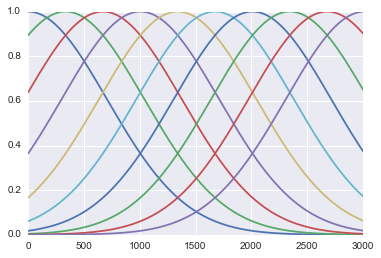

In [147]:
scale = 1000
plot_basis_functions(np.linspace(0,3000,400), kernel_spacing, scale)


Make a big RF. then fit a model that does a weighted linear regression on the tree outputs, weighted by the time difference.
Fit a bunch of localized RFs, where you bootstrap sample, and then 

In [198]:
use_cols = ['int_rate','term','funded_amnt','location','home_ownership','purpose',
                    'collections_12_mths_ex_med','delinq_2yrs','desc_length',
                    'dti','cr_line_dur','emp_length', 'annual_inc','open_acc',
                    'mths_since_last_delinq', 'inq_last_6mths',
                    'mths_since_last_record','pub_rec','revol_bal','total_acc']

n_trees = 10
trees_per_patch = 10
max_depth= 10
min_samples_leaf = 100

scale = 500.

loc_RF = []
# slope = 1./1500

shuf_split = ShuffleSplit(len(LD), n_iter=1, test_size=0.1)
for train, test in shuf_split:
#     Full_mod = RF_mod(use_cols,col_dict,n_trees=n_trees,max_depth=max_depth,
#                       min_samples_leaf=min_samples_leaf)
#     Full_mod.fit(X[train,:],y.iloc[train])
    for idx, kern_cent in enumerate(kernel_spacing):
        print('Fitting section {} of {}'.format(idx,len(kernel_spacing)))
        new_patch_mod = [RF_mod(use_cols,col_dict,bootstrap=False,
                             n_trees=1,max_depth=max_depth,
                              min_samples_leaf=min_samples_leaf) for _ in xrange(trees_per_patch)]
#         loc_RF.append(RF_mod(use_cols,col_dict,bootstrap=False,
#                              n_trees=n_trees,max_depth=max_depth,
#                               min_samples_leaf=min_samples_leaf))    
#         weights = get_weights(time_ax.iloc[train].values, kern_cent, kernel_SD)
        weights = get_weights(time_ax.iloc[train].values, kern_cent, scale)
        for tree_idx in xrange(trees_per_patch):
            print('fitting tree {} of {}'.format(tree_idx,trees_per_patch))
            sample = np.random.choice(len(train),size=len(train), replace=True)
            sample = sample[(np.random.rand(len(train)) < weights[sample])]
            new_patch_mod[tree_idx].fit(X[train[sample],:],y.iloc[train[sample]]) 
        loc_RF.append(new_patch_mod)
#         loc_RF[idx].fit(X[train[sample],:],y.iloc[train[sample]]) 
        print(len(sample))

674220
Fitting section 0 of 10
fitting tree 0 of 10
fitting tree 1 of 10
fitting tree 2 of 10
fitting tree 3 of 10
fitting tree 4 of 10
fitting tree 5 of 10
fitting tree 6 of 10
fitting tree 7 of 10
fitting tree 8 of 10
fitting tree 9 of 10
1516
Fitting section 1 of 10
fitting tree 0 of 10
fitting tree 1 of 10
fitting tree 2 of 10
fitting tree 3 of 10


KeyboardInterrupt: 

In [ ]:
# time_pts = time_ax.iloc[train].values
# weights = get_weights(time_pts, kern_cent, slope)
# kern_cent
# plt.plot(time_pts,weights,'.')

In [150]:
all_weights = np.zeros((len(kernel_spacing),len(test)))
all_preds = np.zeros((len(kernel_spacing),len(test)))
Full_pred = Full_mod.predict(X[test,:])
for idx, kern_cent in enumerate(kernel_spacing):
#     all_weights[idx,:] = get_weights(time_ax.iloc[test].values, kern_cent, kernel_SD)
    all_weights[idx,:] = get_weights(time_ax.iloc[test].values, kern_cent, scale)
    patch_preds = np.zeros((trees_per_patch,len(test)))
    for tree_idx in xrange(trees_per_patch):
        patch_preds[tree_idx,:] = loc_RF[idx][tree_idx].predict(X[test,:])
    all_preds[idx,:] = np.mean(patch_preds,axis=0)
#     all_preds[idx,:] = loc_RF[idx].predict(X[test,:])


In [138]:
all_weights

array([[  3.85746061e-01,   4.00623401e-07,   1.52078985e-09, ...,
          3.40567177e-13,   1.74578831e-13,   4.99015479e-10],
       [  9.10490285e-01,   4.37231849e-05,   4.06126586e-07, ...,
          2.84744849e-10,   1.58603909e-10,   1.56921029e-07],
       [  8.76189715e-01,   1.94552261e-03,   4.42183622e-05, ...,
          9.70639543e-08,   5.87469345e-08,   2.01185785e-05],
       ..., 
       [  1.03382633e-06,   4.85170088e-01,   9.67261907e-01, ...,
          6.38710076e-01,   5.85567667e-01,   9.96353135e-01],
       [  4.56945633e-09,   9.91545431e-02,   4.83703716e-01, ...,
          9.99999951e-01,   9.96190780e-01,   5.86710073e-01],
       [  8.23437212e-12,   8.26190573e-03,   9.86197237e-02, ...,
          6.38329928e-01,   6.90966456e-01,   1.40858421e-01]])

In [81]:
cur_preds = np.sum(all_weights * all_preds, axis=0) / np.sum(all_weights, axis=0)

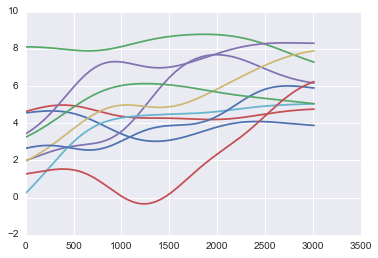

In [160]:
examp_pts = np.random.choice(len(test), size=(10,), replace=False)
base_preds = all_preds[:,examp_pts]
poss_times = np.linspace(min_time,max_time,500)
weight_arr = np.zeros((len(kernel_spacing),len(poss_times)))
for idx, kern_cent in enumerate(kernel_spacing):
#     weight_arr[idx,:] = 1.5 * np.exp(-(poss_times - kern_cent)**2 / (2*kernel_SD**2))
#     weight_arr[idx,weight_arr[idx,:] > 1] = 1
    weight_arr[idx,:] = get_weights(poss_times, kern_cent, scale)
tot_weight = np.sum(weight_arr, axis=0)

time_preds = np.sum(base_preds[:,np.newaxis,:] * weight_arr[:,:,np.newaxis], axis=0) 
time_preds = time_preds / tot_weight[:,np.newaxis]
time_preds[tot_weight == 0,:] = 0

plt.plot(poss_times,time_preds)

In [158]:
examp_pts = np.random.choice

In [ ]:
base_preds[:,np.newaxis,:].shape

In [ ]:
shuf_split = train_test_split

In [ ]:
(train, test)


In [ ]:

for loc in xrange(n_kern_pos):
    cur_kern_cent = kernel_spacing[loc]
    test_grid = np.linspace(min_time,max_time,500)
    weights = 1.5*np.exp(-(test_grid - cur_kern_cent)**2 / (2*kernel_SD**2))
    weights[weights > 1] = 1
    plt.plot(test_grid,weights)


In [ ]:
Full_RF_mod.fit(X,y)

In [ ]:
sf = ShuffleSplit?

In [ ]:
sf = ShuffleSplit